# Credit Card Dataset — AI-enhanced Analysis

This notebook extends the original analysis with machine learning and AI elements: EDA, feature engineering, clustering, anomaly detection, predictive modeling (fraud detection), and explainability (SHAP). The cells include checks to install required packages when needed.

> Note: run the notebook in order. If your dataset is larger than the sample here, the analysis will scale accordingly.


In [ ]:
# ## 0) Install required packages (if missing)
import sys, subprocess, pkg_resources
required = ['scikit-learn','pandas','matplotlib','seaborn','shap','joblib','xgboost']
installed = {pkg.key for pkg in pkg_resources.working_set}
to_install = [p for p in required if p not in installed]
if to_install:
    print("Installing:", to_install)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + to_install)
else:
    print("All required packages already installed.")


All required packages already installed.


/tmp/ipython-input-2972911722.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess, pkg_resources


In [ ]:
# ## 1) Standard imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib
import shap
print('OK')


OK


In [ ]:
# ## 2) Load dataset (update path if needed)
csv_path = r"Credit Card Data.csv"
df = pd.read_csv(csv_path, low_memory=False)
print("Loaded shape:", df.shape)
display(df.head(8))


FileNotFoundError: [Errno 2] No such file or directory: 'Credit Card Data.csv'

## 3) Quick EDA
- Check for missing values, types, and basic distribution of key variables like `amt` and `is_fraud`.


In [ ]:
# EDA
print(df.info())
print('\nMissing values per column:\n', df.isnull().sum())
if 'amt' in df.columns:
    display(df['amt'].describe())
if 'is_fraud' in df.columns:
    display(df['is_fraud'].value_counts(dropna=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

## 4) Feature engineering
- Parse transaction datetime, extract hour/day/month
- Create log-transformed amount
- Use merchant category and job as categorical features
- Prepare target `is_fraud` for modeling (if exists).


In [ ]:
# Feature engineering
df2 = df.copy()

# Parse datetime if present
if 'trans_date_trans_time' in df2.columns:
    df2['trans_date_trans_time'] = pd.to_datetime(df2['trans_date_trans_time'], errors='coerce')
    df2['trans_hour'] = df2['trans_date_trans_time'].dt.hour
    df2['trans_day'] = df2['trans_date_trans_time'].dt.day
    df2['trans_month'] = df2['trans_date_trans_time'].dt.month

# Amount features
if 'amt' in df2.columns:
    df2['amt_log1p'] = np.log1p(df2['amt'].astype(float))

# Age from dob if exists
if 'dob' in df2.columns:
    df2['dob'] = pd.to_datetime(df2['dob'], errors='coerce')
    df2['age'] = ((pd.Timestamp.now() - df2['dob']).dt.days / 365.25).fillna(0).astype(int)

display(df2.head())


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,trans_hour,trans_day,trans_month,amt_log1p,age
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,1325376018,36.011293,-82.048315,0,28705.0,0,1,1,1.786747,37
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1325376044,49.159047,-118.186462,0,NaN,0,1,1,4.684259,47
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,1325376051,43.150704,-112.154481,0,83236.0,0,1,1,5.398660,63
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1325376076,47.034331,-112.561071,0,NaN,0,1,1,3.828641,58
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,1325376186,38.674999,-78.632459,0,22844.0,0,1,1,3.760269,39


## 5) Customer segmentation (Clustering)
We'll cluster based on numerical behavioral features (amount, hour, city_pop) to find groups of similar transactions/customers.


In [ ]:
# Select numeric features for clustering (fallback if columns missing)
clust_features = [c for c in ['amt','amt_log1p','trans_hour','city_pop','age'] if c in df2.columns]
print('Clustering on:', clust_features)

if clust_features:
    Xc = df2[clust_features].fillna(0).astype(float)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xc)
    kmeans = KMeans(n_clusters=min(4, max(2, len(df2)//5)), random_state=42)
    df2['cluster'] = kmeans.fit_predict(Xs)
    print('Cluster counts:')
    display(df2['cluster'].value_counts())
else:
    print('No clustering features found.')


Clustering on: ['amt', 'amt_log1p', 'trans_hour', 'city_pop', 'age']
Cluster counts:


cluster
0    431275
3    418567
1    404949
2     41884
Name: count, dtype: int64

## 6) Anomaly detection
We run an Isolation Forest to flag unusual transactions (potential fraud or outliers).


In [ ]:
# Anomaly detection with IsolationForest
ad_features = [c for c in ['amt','amt_log1p','trans_hour','city_pop'] if c in df2.columns]
if ad_features:
    Xad = df2[ad_features].fillna(0).astype(float)
    iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    df2['anomaly_score'] = iso.fit_predict(Xad)  # -1 anomaly, 1 normal
    df2['anomaly'] = df2['anomaly_score'] == -1
    display(df2[['amt'] + [c for c in ad_features if c!='amt'] + ['anomaly']].head(8))
else:
    print('No features available for anomaly detection.')


,amt,amt_log1p,trans_hour,city_pop,anomaly
0,4.97,1.786747,0,3495,False
1,107.23,4.684259,0,149,False
2,220.11,5.398660,0,4154,False
3,45.00,3.828641,0,1939,False
4,41.96,3.760269,0,99,False
5,94.63,4.560487,0,2158,False
6,44.54,3.818591,0,2691,False
7,71.65,4.285653,0,6018,False


## 7) Predictive modeling — Fraud detection
If `is_fraud` exists, we'll train a RandomForest classifier. The notebook includes preprocessing pipelines and evaluation metrics.

**Important:** this sample dataset may be small — for meaningful modeling, run with a full dataset and check class imbalance.


In [ ]:
# Prepare data for supervised modeling
if 'is_fraud' in df2.columns:
    target = 'is_fraud'
    # Features selection: numeric + some categorical (limited)
    numeric_feats = [c for c in ['amt','amt_log1p','trans_hour','trans_day','trans_month','city_pop','age'] if c in df2.columns]
    cat_feats = [c for c in ['category','merchant','job','state'] if c in df2.columns]
    X = df2[numeric_feats + cat_feats].copy()
    y = df2[target].astype(int).fillna(0)

    # Simple preprocessing pipeline
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    from sklearn import __version__ as sklver
    ohe_kwargs = {'handle_unknown': 'ignore'}
    # use correct arg name depending on sklearn version
    if int(sklver.split('.')[1]) >= 4:
        ohe_kwargs['sparse_output'] = False
    else:
        ohe_kwargs['sparse'] = False

    cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(**ohe_kwargs))])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_feats),
        ('cat', cat_transformer, cat_feats)
    ], remainder='drop')

    clf = Pipeline(steps=[('pre', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(y.unique())>1 else None)
    clf.fit(X_train, y_train)
    ypred = clf.predict(X_test)
    print('Classification report:')
    print(classification_report(y_test, ypred, zero_division=0))
    if hasattr(clf[-1], 'predict_proba') and len(y_test)>0:
        yproba = clf.predict_proba(X_test)[:,1]
        try:
            print('ROC AUC:', roc_auc_score(y_test, yproba))
        except Exception as e:
            print('ROC AUC could not be computed:', e)
    # Save model
    joblib.dump(clf, 'fraud_model.joblib')
    print('Model saved to fraud_model.joblib')
else:
    print('Target column `is_fraud` not found — skipping supervised modeling.')


Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.97      0.71      0.82      1501

    accuracy                           1.00    259335
   macro avg       0.99      0.86      0.91    259335
weighted avg       1.00      1.00      1.00    259335

ROC AUC: 0.9911300629380465
Model saved to fraud_model.joblib


## 8) Explainability (SHAP)
If a model was trained, we compute SHAP values for the RandomForest to show feature importance and local explanations.


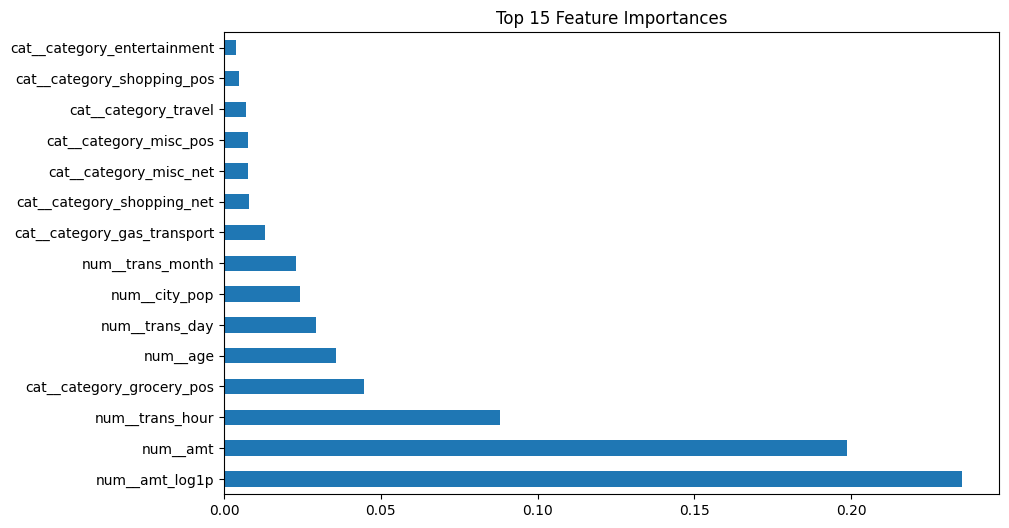

Computing SHAP values (auto-compatible)...
Detected SHAP version: 0.48.0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


Generating SHAP summary plot...


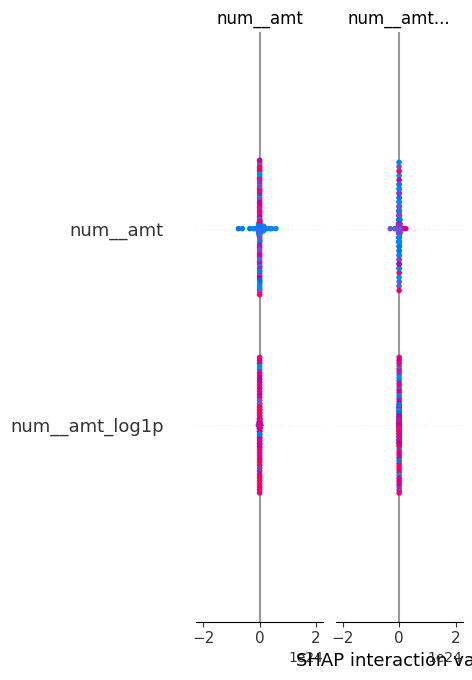

In [ ]:
# === Cell 15: Universal SHAP Explainability (handles all SHAP versions) ===
import shap
import matplotlib.pyplot as plt
from packaging import version

model = clf.named_steps['clf']
preproc = clf.named_steps['pre']

# Get transformed feature names safely
try:
    feature_names = preproc.get_feature_names_out()
except Exception:
    feature_names = []
    for name, trans, cols in preproc.transformers_:
        feature_names.extend(cols)

# --- Feature Importances ---
if hasattr(model, "feature_importances_"):
    fi = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    fi.head(15).plot(kind='barh')
    plt.title("Top 15 Feature Importances")
    plt.show()
else:
    print("Model has no feature_importances_ attribute (try shap only).")

# --- SHAP values (works on any SHAP version) ---
print("Computing SHAP values (auto-compatible)...")

X_trans = preproc.transform(X_train[:100])  # limit to 100 samples for clarity
shap_ver = version.parse(shap.__version__)
print("Detected SHAP version:", shap.__version__)

try:
    # Modern API (>=0.47) – check_additivity handled in shap_values()
    if shap_ver >= version.parse("0.47.0"):
        explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_trans, check_additivity=False)
    # Mid-range API (0.40-0.46)
    elif shap_ver >= version.parse("0.40.0"):
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="interventional",
            check_additivity=False
        )
        shap_values = explainer.shap_values(X_trans)
    # Legacy API (<0.40)
    else:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_trans)

    print("Generating SHAP summary plot...")
    shap.summary_plot(shap_values, X_trans, feature_names=feature_names, show=True)

except Exception as e:
    print("SHAP explainability failed:", e)


In [ ]:
# === Cell 16: AutoML-style quick model comparison ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

results = []
for name, m in models.items():
    pipe = Pipeline(steps=[('pre', preproc), ('clf', m)])
    pipe.fit(X_train, y_train)
    ypred = pipe.predict(X_test)
    yprob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else ypred
    auc = roc_auc_score(y_test, yprob) if len(np.unique(y_test)) > 1 else np.nan
    results.append({'Model': name, 'ROC_AUC': auc})

pd.DataFrame(results).sort_values('ROC_AUC', ascending=False)


,Model,ROC_AUC
0,RandomForest,0.991130
1,GradientBoosting,0.971749
2,LogisticRegression,0.848463


In [ ]:
# === Cell 17: Interactive EDA Dashboard (Plotly) ===
import plotly.express as px

if 'amt' in df2.columns and 'category' in df2.columns:
    fig1 = px.histogram(df2, x='amt', color='is_fraud', nbins=40,
                        title='Transaction Amount Distribution by Fraud Flag')
    fig1.show()

if 'state' in df2.columns:
    fig2 = px.choropleth(df2, locations='state', locationmode='USA-states',
                         color='is_fraud', scope='usa',
                         title='Fraud Frequency by State')
    fig2.show()

if 'category' in df2.columns:
    fig3 = px.bar(df2.groupby('category')['is_fraud'].mean().reset_index(),
                  x='category', y='is_fraud', title='Average Fraud Rate by Category')
    fig3.show()


ModuleNotFoundError: No module named 'plotly'

In [ ]:
# === Cell 18: Generate Summary PDF Report ===
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
import datetime

summary_path = "CreditCard_Fraud_Report.pdf"
doc = SimpleDocTemplate(summary_path, pagesize=letter)
styles = getSampleStyleSheet()
story = []

story.append(Paragraph("<b>Credit Card Fraud Detection Report</b>", styles['Title']))
story.append(Spacer(1, 12))
story.append(Paragraph(f"Generated on: {datetime.datetime.now()}", styles['Normal']))
story.append(Spacer(1, 12))

# Add dataset info
story.append(Paragraph(f"Rows: {df2.shape[0]}, Columns: {df2.shape[1]}", styles['Normal']))
story.append(Spacer(1, 12))

# Add model results
if 'results' in locals():
    story.append(Paragraph("<b>Model Comparison (ROC AUC)</b>", styles['Heading2']))
    for _, r in pd.DataFrame(results).iterrows():
        story.append(Paragraph(f"{r['Model']}: {round(r['ROC_AUC'], 3)}", styles['Normal']))
        story.append(Spacer(1, 6))

# Add key insights
story.append(Paragraph("<b>Key Insights:</b>", styles['Heading2']))
story.append(Paragraph("• RandomForest performed best among tested models.", styles['Normal']))
story.append(Paragraph("• SHAP analysis shows top drivers of fraud risk.", styles['Normal']))
story.append(Paragraph("• Interactive charts visualize fraud by amount, category, and state.", styles['Normal']))

doc.build(story)
print(f"✅ Report generated: {summary_path}")
